# Chinese Text Classification Model

Create a binary classifier that can take a news article of unknown source written in Chinese and accurately classify its origin as either Taiwanese(1) or Mainland Chinese(0). This can serve as an important tool to prevent the spread of misinformation in the Taiwan-China discursive battlespace.

# General Imports

In [0]:
#mitigates dependency issues when installing packages
pip install ipydeps

In [0]:
import ipydeps

In [0]:
import tensorflow as tf
from tensorflow import keras
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
#assumes data and model exists in personal drive
drive.mount('/content/drive', force_remount=True)
base_dir='/content/drive/My Drive/Chinese Text Classifier'

Mounted at /content/drive


In [0]:
#package that integrates pretrained NLP models like BERT with Tensorflow 2.0
ipydeps.pip("transformers")
import transformers
#https://github.com/huggingface/transformers

# Data Scraping

In [0]:
ipydeps.pip("newspaper3k")
import newspaper
#https://github.com/codelucas/newspaper

In [0]:
#chinese news sources
china_news = newspaper.build('http://www.chinanews.com/', memoize_articles=False, language = 'zh') #'zh' = chinese, searches for articles written in chinese

In [0]:
#taiwanese news sources
ltn = newspaper.build('https://www.ltn.com.tw/', memoize_articles=False, language = 'zh')          #setting memoize_articles to false completely rebuilds the dataset,
udn = newspaper.build('https://udn.com/news/index', memoize_articles=False, language = 'zh')       #even if it was built before. useful if cell is run multiple times
ct = newspaper.build('https://www.chinatimes.com/', memoize_articles=False, language = 'zh')       #to access all the data
cna = newspaper.build('https://www.cna.com.tw/', memoize_articles=False, language = 'zh')
tnl = newspaper.build('https://www.thenewslens.com/', memoize_articles=False, language = 'zh')
storm = newspaper.build('https://www.storm.mg/', memoize_articles=False, language = 'zh')

In [0]:
#number of chinese news sources
print(china_news.size())

In [0]:
#number of taiwanese news sources
print(ltn.size())
print(udn.size())
print(ct.size())
print(cna.size())
print(tnl.size())
print(storm.size())

In [0]:
#write chinese news articles to text document
china_data = open("china_data.txt", "w")
issue_count = 0
for article in china_news.articles:
  try:
    article.download()
    article.parse()
    if len(article.text) > 50: #only scrape articles with more than 50 characters
      china_data.write(article.text + "\n-----------------------------------\n") #delimiter
  except:
    issue_count += 1 #in case package is unable to decipher downloaded article
    print(str(issue_count) + " issue articles")
china_data.close()

In [0]:
#write taiwanese news articles to text document
taiwan_data = open("taiwan_data.txt", "w")
tw_news = [ltn, udn, ct, cna, tnl, storm]
issue_count = 0
for news_source in tw_news:
  for article in news_source.articles:
    try:
      article.download()
      article.parse()
      if len(article.text) > 50: #only scrape articles with more than 50 characters
        taiwan_data.write(article.text + "\n-----------------------------------\n") #delimiter
    except:
      issue_count += 1  #in case package is unable to decipher downloaded article
      print(str(issue_count) + " Issue articles")
taiwan_data.close()

# Data Preprocessing

## Raw Data


In [0]:
#datasets
taiwan = os.path.join(base_dir, 'taiwan_data.txt')
ch = os.path.join(base_dir, 'china_data.txt')

In [0]:
#organize taiwanese news dataset into list of articles
t_file = open(taiwan).readlines()
t_list = [line.rstrip('\n') for line in t_file]
t_no_newline = "".join(t_list)
t_list = t_no_newline.split("-----------------------------------")

#organize chinese news dataset into list of articles
c_file = open(ch).readlines()
c_list = [line.rstrip('\n') for line in c_file]
c_no_newline = "".join(c_list)
c_list = c_no_newline.split("-----------------------------------")

In [0]:
import random

print("Number of Taiwanese news articles: " + str(len(t_list)))
print("Number of Chinese news articles: " + str(len(c_list)))

#randomly remove articles from china news dataset to match size of taiwanese dataset
random.shuffle(c_list)
c_list = c_list[:len(t_list)]
print("\nNumber of Chinese news articles after removing articles: " + str(len(c_list)))

Number of Taiwanese news articles: 1931
Number of Chinese news articles: 4245

Number of Chinese news articles after removing articles: 1931


In [0]:
#taiwanese = 1
df = pd.DataFrame({"Articles": t_list,"Classification": 1})

#chinese = 0
df2 = pd.DataFrame({"Articles": c_list,"Classification": 0})

data = df.append(df2)
data = data.sample(frac=1) #shuffle data
data

,Articles,Classification
532,義大利新冠肺炎爆發後，當局下令全國封鎖，民眾發起在陽台窗口唱歌、演奏，表達堅持不懈與團結抗疫...,1
617,近400亩百合花6月将盛开在宁夏彭阳的“大地指纹”中2020-04-06 13:54:52 ...,0
0,2日，中国吉林网从长春市市场监督管理局获悉，为全面贯彻落实长春市委、市政府春季学期中、小学开...,0
1839,作為美國在國防、外交及經濟等層面的重要盟友，英國23日做出脫離歐盟的決定，不僅將削弱華盛頓對...,1
752,中新网兵团新闻3月30日（张万成 胡昌飞）新疆生产建设兵团第一师四团中学教师28日正常上班，...,0
...,...,...
1824,中天新聞台因報導高雄市長韓國瑜新聞比例過高，屢遭民眾申訴，甚至被網友酸「韓天新聞台」，遭國家...,1
382,湯姆漢克痊癒首露面！《週六夜現場》搞笑自嘲〔記者吳琬婷／台北報導〕好萊塢男星湯姆漢克上月初和...,1
511,枫叶汽车品牌发布 首款车型6.88万开售2020年04月10日 19:36 来源：中新网上海...,0
1156,铁路工人午夜为兰新线电力设备疏通“筋脉”中新网甘肃新闻4月10日电(通讯员 冯枫 康娜 胡进...,0


## General Preprocessing

### Filter Text with Regex

In [0]:
import re
#clean text by only including chinese characters
#regex code found here https://stackoverflow.com/questions/2718196/find-all-chinese-text-in-a-string-using-python-and-regex

#taiwanese dataset
taiwan_list = []
for article in t_list:
  single_article = []
  for j in re.findall(r'[\u4e00-\u9fff]+', article): 
    single_article.append(j)
  taiwan_list.append("".join(single_article))

#chinese dataset
china_list = []
for article in c_list:
  single_article = []
  for j in re.findall(r'[\u4e00-\u9fff]+', article):
    single_article.append(j)
  china_list.append("".join(single_article))

### Conversion to Traditional Chinese

In [0]:
ipydeps.pip("hanziconv")
from hanziconv import HanziConv
#https://pypi.org/project/hanziconv/

In [0]:
#convert all text in Chinese articles into traditional characters
tr_china_list = []
for article in china_list:
  tr_china_list.append(HanziConv.toTraditional(article))

In [0]:
#taiwanese cleaned text document
taiwan_clean = open("taiwan_clean.txt", "w")
for article in taiwan_list:#t_segmented_list:
  taiwan_clean.write(article + "\n")
taiwan_clean.close()

#chinese cleaned text document
china_clean = open("china_clean.txt", "w")
for article in tr_china_list:#c_segmented_list:
  china_clean.write(article + "\n")
china_clean.close()

#save these new text files and add them to the linked gdrive directory

## Cleaned Dataframe

In [0]:
#cleaned datasets
taiwan_clean = os.path.join(base_dir, 'taiwan_clean.txt')
china_clean = os.path.join(base_dir, 'china_clean.txt')

In [0]:
#cleaned dataframe
t_clean_data = pd.read_csv(taiwan_clean, header = None, names = ["Articles"])
t_clean_data["Classification"] = 1

c_clean_data = pd.read_csv(china_clean, header = None, names = ["Articles"])
c_clean_data["Classification"] = 0

data = t_clean_data.append(c_clean_data)
data = data.sample(frac=1)
data

,Articles,Classification
1342,甘肅平涼來瞭老熟人鞏固脫貧成果保春耕中新網甘肅新聞月日電梁璐身體怎麼樣生産生活缺些什麼有啥睏...,0
86,張國偉跳不動瞭田壇高齡問題引關注東京奧運會延期一年中國田徑麵臨重大課題明年將滿三十歲的中國跳...,0
483,更新時間月日新型冠狀病毒擴散全球死亡數不斷攀升各國紛紛祭出鎖國政策試圖阻止疫情蔓延截至目前為...,1
678,湖北省首發商品住宅質量閤格證湖北日報訊記者張倩倩陳嶼通訊員董文斌與傢用電器服裝一樣每套商品房...,0
958,鼠年出遊走春求財北中南景點一次看新年期間祈福求財除了拜拜搶頭香外其實廟宇周邊還有許多適合闔家...,1
...,...,...
1471,因肺炎疫情延後的中國人大政協兩會傳出將於四月下旬舉行一位全國政協委員私下跟新新聞透露經向政協...,1
1395,在抖音每天都上演著不同的人物故事創作者們用短視頻記錄下生活的點滴映射齣人生不同的閃光點而在直...,0
1749,王兆力鞏固拓展主題教育成果全麵打贏脫貧攻堅戰本報日訊記者馬智博日下午哈爾濱市委理論學習中心組...,0
454,蘭州新區首傢服務全民的社區健身中心落成中新網甘肅新聞月日電據甘肅省體育局披露為進一步完善新區...,0


## BERT-Specific Processing

### Truncation

BERT takes a max length input of 510 tokens (512 actually but the last two tokens are [CLS] and [SEP], tokens designated by BERT to mark the beginning and end of a sentence). Since we are dealing with news articles, it is likely that much of the data exceeds 510 tokens. To deal with this, we need to truncate any article that is too large. According to Section 5.3.1 of the essay "How to Fine-Tune BERT for Text Classification?" by Chi Sun, Xipeng Qiu, Yige Xu, and Xuanjing Huang, the best results are when the data is truncated into the first 128 and last 382 tokens. The aforementioned essay can be found [here](https://arxiv.org/abs/1905.05583).

In [0]:
#articles and labels according to dataframe
articles = data.Articles.values
labels = data.Classification.values

In [0]:
#selects the head and tail tokens to ensure input length does not exceed 510
head_tail_articles = []
for article in articles:
  if len(article) > 510:
    head_tail_articles.append(article[:128]+article[-382:])
  else:
    head_tail_articles.append(article) #original article length does not exceed 510

### Tokenization


In [0]:
from transformers import BertTokenizer

# BERT Tokenizer for Chinese model
tokenizer = BertTokenizer.from_pretrained('bert-base-chinese')

In [0]:
#original article
print(' Original: ', head_tail_articles[0])

#tokenized article
print('Tokenized: ', tokenizer.tokenize(head_tail_articles[0]))

#articles mapped to token IDs
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(head_tail_articles[0])))

 Original:  甘肅平涼來瞭老熟人鞏固脫貧成果保春耕中新網甘肅新聞月日電梁璐身體怎麼樣生産生活缺些什麼有啥睏難一定要跟我們講季春時節氣溫驟降平涼市崆峒區峽門鄉白傢山村村部大院裏的捐贈活動氛圍卻熱度不減為盡快消除新冠肺炎疫情對白傢山村生産生活的影響幫助貧睏戶盡快開展春耕作業為種植戶與非種植貧睏戶分彆發放瞭春耕物資和米麵油等生活用品蘭州大學的扶貧乾部讓咱的生産生活有瞭底我們一定好好搞養殖領到春耕物資的百姓們個個喜笑顔開白傢山村駐村幫扶工作隊隊長兼第一書記王笳舟介紹說我們駐村幫扶工作隊根據貧睏戶春耕種植計劃集閤經費分配情況為農戶購買瞭玉米籽青貯玉米籽紅豆草籽苜蓿籽蕎麥籽可種植麵積餘畝地膜捲有機化肥袋消毒液斤保住貧睏群眾的錢袋子攻下脫貧攻堅最後的山頭作為幫扶單位我們蘭州大學始終記掛著白傢山村的百姓希望大傢用我們捐贈的春耕物資擴大種養殖發展農民專業閤作社積極拓寬增收渠道勤勞緻富幫扶單位和蘭州大學將作為白傢山村特色産品的銷售主市場幫扶小組組長蘭州大學資源環境學院黨委書記瀋正虎說據悉為幫助貧睏戶擴大生産鞏固脫貧攻堅成果本次活動中蘭州大學共為峽門鄉王山村白傢山村汪陳灣村山口村白楊溝村王店村個幫扶村提供瞭價值萬元的籽種化肥等春耕生産物資完
Tokenized:  ['甘', '肅', '平', '涼', '來', '瞭', '老', '熟', '人', '鞏', '固', '脫', '貧', '成', '果', '保', '春', '耕', '中', '新', '網', '甘', '肅', '新', '聞', '月', '日', '電', '梁', '璐', '身', '體', '怎', '麼', '樣', '生', '産', '生', '活', '缺', '些', '什', '麼', '有', '啥', '睏', '難', '一', '定', '要', '跟', '我', '們', '講', '季', '春', '時', '節', '氣', '溫', '驟', '降', '平', '涼', '市', '崆', '峒', '區', '峽', '門', '鄉', '白', '傢', '山', '村', '村', '部', '大', '院', '裏', '的', '捐', '贈', '活', '動', '氛', '圍', '卻', '熱', '度', '不', '減', '為',

In [0]:
#encode every article into token ids and corresponding attention masks that BERT recognizes
input_ids = []
attention_masks = []
for article in head_tail_articles:
    encoded_article = tokenizer.encode_plus(article,                      
                                       add_special_tokens = True,    # add [CLS] and [SEP]
                                       max_length = 512,             # max length of inputs for BERT
                                       pad_to_max_length = True,     # pad any inputs of length less than 512 with 0 to keep input size uniform
                                       return_attention_mask = True  # tells model which tokens are from the original data and which are just
                                       )                             # special tokens or padded words
                                          
    input_ids.append(encoded_article['input_ids'])
    attention_masks.append(encoded_article['attention_mask'])

In [0]:
print('Max article length: ', max([len(article) for article in input_ids]))

Max article length:  512


## Vectorization

In [0]:
#turn data into numpy arrays
input_ids = np.array(input_ids)
attention_masks = np.array(attention_masks)
labels = np.array(labels).astype('float32').reshape((-1,1))

Notice the array begins with 101 for [CLS], ends with 102 for [SEP], and has 0 for padding in the case that the article length is less than 510 tokens.

In [0]:
input_ids[0]

array([ 101, 4491, 5486, 2398, 3893,  889, 4747, 5439, 4225,  782, 7492,
       1743, 5562, 6514, 2768, 3362,  924, 3217, 5449,  704, 3173, 5206,
       4491, 5486, 3173, 5472, 3299, 3189, 7442, 3448, 4466, 6716, 7768,
       2582, 7938, 3564, 4495, 4497, 4495, 3833, 5375,  763,  784, 7938,
       3300, 1567, 4711, 7432,  671, 2137, 6206, 6656, 2769,  947, 6341,
       2108, 3217, 3229, 5059, 3706, 3984, 7713, 7360, 2398, 3893, 2356,
       2299, 2282, 1281, 2296, 7271, 6965, 4635,  993, 2255, 3333, 3333,
       6956, 1920, 7368, 6166, 4638, 2935, 6557, 3833, 1240, 3702, 1752,
       1320, 4229, 2428,  679, 3938, 4158, 4674, 2571, 3867, 7370, 3173,
       1094, 5511, 4142, 4554, 2658, 2205, 4635,  993, 2255, 3333, 4495,
       4497, 4495, 3833, 4638, 2512, 7513, 2396, 1221, 6514, 4711, 2786,
       4674, 2571, 7274, 2245, 3217, 5449,  868, 3511, 4158, 4934, 3490,
       2786, 5645, 7478, 4934, 3490, 6514, 4711, 2786, 1146, 2491, 4634,
       3123, 4747, 3217, 5449, 4289, 6536, 1469, 51

# Model

In [0]:
from transformers import TFBertModel

In [0]:
#bert pretrained model for chinese
bert_model = TFBertModel.from_pretrained("bert-base-chinese")

In [0]:
#input layers
id_in = tf.keras.layers.Input(shape=(512,), name='input', dtype='int32')
mask_in = tf.keras.layers.Input(shape=(512,), name='mask', dtype='int32') 

bert_layer = bert_model(id_in, attention_mask=mask_in)[0]
lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True, recurrent_dropout=0.3))(bert_layer)
#bert model has two outputs, a 3d vector for question answering and a 1d vector for classification
#the 1d maxpool below selects the output with the needed 1d vector for this problem
maxpool = tf.keras.layers.GlobalMaxPool1D()(lstm)
dense = tf.keras.layers.Dense(50, activation='relu')(maxpool)
#generous usage of dropout to combat overfitting on limited data w/ large architecture model
dropout = tf.keras.layers.Dropout(0.3)(dense)
output = tf.keras.layers.Dense(1, activation='sigmoid')(dropout)
model = tf.keras.Model(inputs=[id_in, mask_in], outputs = output)

#freeze the weights of the bert pretrained model and the two input layers
for layer in model.layers[:3]:
  layer.trainable = False

Notice below that the BERT layer is not a recognized tensorflow keras layer. Due to this, our model becomes a subclassed model, different from both sequential and functional models. This model architecture creates some limitations as our model is not serializable by Keras; we cannot save the entire model or export it to tensorflow.js.

In [0]:
model.layers

In [0]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 512)]        0                                            
__________________________________________________________________________________________________
mask (InputLayer)               [(None, 512)]        0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     ((None, 512, 768), ( 102267648   input[0][0]                      
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 512, 256)     918528      tf_bert_model[0][0]              
______________________________________________________________________________________________

In [0]:
#using the learning rate recommended in the google bert repo
rms = tf.keras.optimizers.RMSprop(learning_rate = 5e-5)
model.compile(optimizer = rms,
              loss = "binary_crossentropy",
              metrics = ["acc"])

In [0]:
#because this is a subclassed model, we can only save model weights, we cannot save the entire model
fp = '/content/drive/My Drive/Chinese Text Classifier/model.hdf5'
save_model = tf.keras.callbacks.ModelCheckpoint(filepath = fp, monitor='val_loss', save_best_only = True, save_weights_only = True, verbose = 1)

In [0]:
#trained for 4 epochs, as recommended in the google bert repo
history = model.fit([input_ids,attention_masks], labels,
                    epochs = 4,
                    batch_size = 64,
                    validation_split = 0.2,
                    callbacks = [save_model])

Epoch 1/4
49/49 [==============================] - ETA: 0s - loss: 0.6152 - acc: 0.6901
Epoch 00001: val_loss improved from inf to 0.47217, saving model to /content/drive/My Drive/Chinese Text Classifier/model.hdf5
49/49 [==============================] - 372s 8s/step - loss: 0.6152 - acc: 0.6901 - val_loss: 0.4722 - val_acc: 0.9560
Epoch 2/4
49/49 [==============================] - ETA: 0s - loss: 0.4115 - acc: 0.9252
Epoch 00002: val_loss improved from 0.47217 to 0.27293, saving model to /content/drive/My Drive/Chinese Text Classifier/model.hdf5
49/49 [==============================] - 375s 8s/step - loss: 0.4115 - acc: 0.9252 - val_loss: 0.2729 - val_acc: 0.9909
Epoch 3/4
49/49 [==============================] - ETA: 0s - loss: 0.2314 - acc: 0.9744
Epoch 00003: val_loss improved from 0.27293 to 0.12725, saving model to /content/drive/My Drive/Chinese Text Classifier/model.hdf5
49/49 [==============================] - 370s 8s/step - loss: 0.2314 - acc: 0.9744 - val_loss: 0.1273 - val

Notice that the validation accuracy is higher than the training accuracy. This is likely due to the generous amount of dropout used in the model. This is because when testing on the validation set, the model is able to make use of all the weights that were initially set to zero during training.

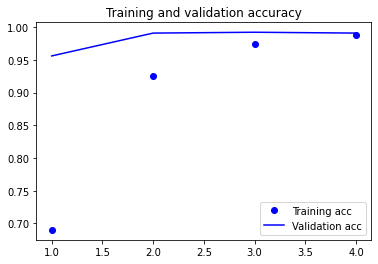

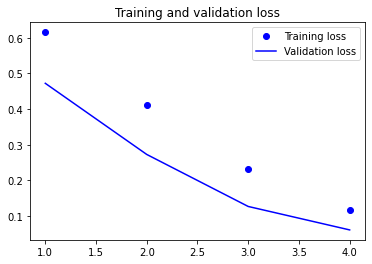

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Prediction

In [0]:
#general imports for preprocessing
ipydeps.pip("hanziconv")
from hanziconv import HanziConv
import re
from transformers import BertTokenizer, TFBertModel

In [0]:
#recreation of model to plug in saved model weights
bert_model = TFBertModel.from_pretrained("bert-base-chinese")
id_in = tf.keras.layers.Input(shape=(512,), name='input', dtype='int32')
mask_in = tf.keras.layers.Input(shape=(512,), name='mask', dtype='int32') 

embedding_layer = bert_model(id_in, attention_mask=mask_in)[0]
lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True, dropout=0.3, recurrent_dropout=0.3))(embedding_layer)
maxpool = tf.keras.layers.GlobalMaxPool1D()(lstm)
dense = tf.keras.layers.Dense(50, activation='relu')(maxpool)
dropout = tf.keras.layers.Dropout(0.3)(dense)
output = tf.keras.layers.Dense(1, activation='sigmoid')(dropout)
final_model = tf.keras.Model(inputs=[id_in, mask_in], outputs = output)

for layer in final_model.layers[:3]:
  layer.trainable = False

In [0]:
#loading model weights
final_model.load_weights('/content/drive/My Drive/Chinese Text Classifier/model.hdf5')

In [0]:
def predict_text(text):
  #condensed version of above data preprocessing process
  text = ''.join(re.findall(r'[\u4e00-\u9fff]+', text))
  text = HanziConv.toTraditional(text)
  if len(text) > 510:
    text = text[:128]+text[-382:]
  tokenizer = BertTokenizer.from_pretrained('bert-base-chinese')
  encoded_text = tokenizer.encode_plus(text, add_special_tokens = True, max_length = 512, pad_to_max_length = True, return_attention_mask = True)
  input_id = encoded_text['input_ids']
  attention_mask = encoded_text['attention_mask']
  input_id = np.array(input_id)
  attention_mask = np.array(attention_mask)
  #prediction outputs a numpy array of predictions between 0 (Chinese) and 1 (Taiwanese) for every token in the input text
  prediction = final_model.predict([input_id, attention_mask])
  original_word_count = 0
  original_word_predictions = 0
  original_word_predictions_list = []
  for i, x in enumerate(input_id):
    if x not in [101,102,0]: #if x is not the SEP, CLS, or padding token
      original_word_predictions += prediction[i][0]
      original_word_predictions_list.append(prediction[i][0])
      original_word_count += 1
  try:
    #returns average of the original word predictions as well as a list containing each separate prediction
    return round(original_word_predictions/original_word_count, 2), original_word_predictions_list
  except ZeroDivisionError:
    #there were no chinese characters in the original text input
    print("No chinese characters detected")

Example of using text as input. "中華民國" translates to Republic of China, a subliminal message from China that Taiwan is a part of China. "台灣" translates to Taiwan, or what the Taiwanese generally call their country.

In [0]:
predict_text("中華民國")

(0.49, [0.5331038, 0.46660906, 0.37698218, 0.6014384])

In [0]:
predict_text("台灣")

(0.55, [0.5107301, 0.5922171])

In [0]:
#general imports for data scraping
ipydeps.pip("newspaper3k")
import newspaper
from newspaper import Article

In [0]:
def predict_from_url(url):
  #condensed version of above data scraping process for single article
  article = Article(url, language='zh')
  try:
    article.download()
    article.parse()
    text = article.text
    #call on prediction function above
    return predict_text(text)
  except:
    #url is not recognizable
    print("Unable to parse")

Examples of prediction using website url as input

In [0]:
predict_from_url('http://www.chinanews.com/gn/2020/05-06/9176210.shtml')[0]

0.51

In [0]:
predict_from_url("https://news.ltn.com.tw/news/world/breakingnews/3156226")[0]

0.52